In [66]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [29]:
df= pd.read_csv("diabetic_data.csv")

In [30]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [31]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                61510 non-null   object
 8   medical_specialty         51817 non-null   object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [101]:
# Load data
df = pd.read_csv("diabetic_data.csv")
df.replace('?', np.nan, inplace=True)

# Drop unnecessary columns
drop_cols = ["encounter_id", "patient_nbr", "weight", "examide", "citoglipton"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# 🔥 Remove rows where A1Cresult is 'None'
df = df[df['A1Cresult'].isin(['Norm', '>7', '>8'])].copy()

# 🎯 Encode A1Cresult as Ordinal Target
a1c_encoder = OrdinalEncoder(categories=[['Norm', '>7', '>8']])
df['A1C_encoded'] = a1c_encoder.fit_transform(df[['A1Cresult']])

# Identify features and target
target_col = 'A1C_encoded'
X = df.drop(columns=['A1Cresult', target_col])
y = df[target_col]

# Separate feature types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Preprocess features
X_processed = preprocessor.fit_transform(X)

# Remove outliers (optional)
outlier_filter = IsolationForest(contamination=0.01, random_state=42)
mask = outlier_filter.fit_predict(X_processed) == 1
X_filtered = X_processed[mask]
y_filtered = y[mask]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
)

In [95]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42,stratify=y_filtered)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                61510 non-null   object
 8   medical_specialty         51817 non-null   object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [107]:
print(a1c_encoder.categories_)  # Should show: [['Norm', '>7', '>8']]



[array(['Norm', '>7', '>8'], dtype=object)]


In [108]:
label_names = [ 'Norm', '>7', '>8']

# Classification report with fixed label order and zero_division handling
print("📊 Classification Report for HbA1c Level Prediction:")
print(classification_report(
    y_test, y_pred,
    labels=[0,1, 2 ],            # Ensure correct label order
    target_names=label_names,       # Friendly label names                # Avoid warnings for missing predictions
))

📊 Classification Report for HbA1c Level Prediction:
              precision    recall  f1-score   support

        Norm       0.50      0.46      0.48       982
          >7       0.36      0.21      0.26       760
          >8       0.64      0.80      0.71      1628

    accuracy                           0.56      3370
   macro avg       0.50      0.49      0.48      3370
weighted avg       0.53      0.56      0.54      3370



In [41]:
!pip install lightgbm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score




[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.5 MB/s eta 0:00:00


In [109]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

labels=[0,1, 2]
print("📊 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, labels=labels, target_names=label_names))

📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

        Norm       0.50      0.46      0.48       982
          >7       0.36      0.21      0.26       760
          >8       0.64      0.80      0.71      1628

    accuracy                           0.56      3370
   macro avg       0.50      0.49      0.48      3370
weighted avg       0.53      0.56      0.54      3370



C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, rf_preds,labels=labels, target_names=label_names))


Random Forest:
              precision    recall  f1-score   support

        Norm       0.51      0.43      0.46       982
          >7       0.37      0.08      0.13       760
          >8       0.60      0.87      0.71      1628

    accuracy                           0.56      3370
   macro avg       0.49      0.46      0.43      3370
weighted avg       0.52      0.56      0.51      3370



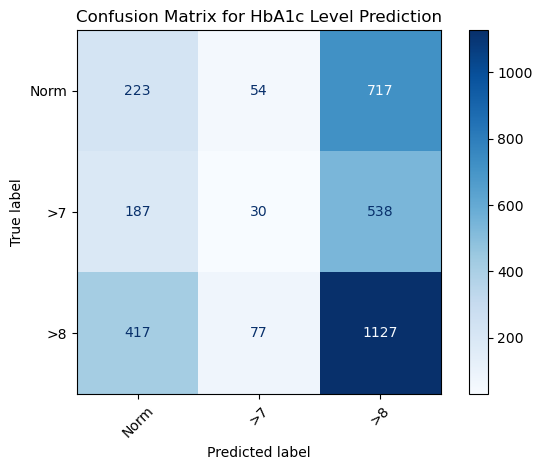

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

present_labels = np.unique(np.concatenate((y_test, y_pred)))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=[label_names[int(l)] for l in present_labels],
    cmap='Blues',
    xticks_rotation=45
)
plt.title("Confusion Matrix for HbA1c Level Prediction")
plt.tight_layout()
plt.show()


In [79]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print("LightGBM:")
print(classification_report(y_test, lgb_preds, labels=labels, target_names=label_names))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 13477, number of used features: 419
[LightGBM] [Info] Start training from score -1.498048
[LightGBM] [Info] Start training from score -0.732881
[LightGBM] [Info] Start training from score -1.217695
LightGBM:
              precision    recall  f1-score   support

        None       0.37      0.16      0.22       760
        Norm       0.64      0.82      0.72      1628
          >7       0.51      0.49      0.50       982
          >8       0.00      0.00      0.00         0

   micro avg       0.57      0.57      0.57      3370
   macro avg       0.38      0.37      0.36      3370
weighted avg       0.54      0.57      0.54      3370



C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHAGYASHREE\anaconda3\Lib\site-packa

In [112]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# Evaluate
print("📊 XGBoost HbA1c Prediction Report:")
print(classification_report(y_test, xgb_preds, target_names=label_names))

C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost HbA1c Prediction Report:
              precision    recall  f1-score   support

        Norm       0.50      0.48      0.49       982
          >7       0.32      0.14      0.19       760
          >8       0.63      0.81      0.71      1628

    accuracy                           0.56      3370
   macro avg       0.48      0.48      0.46      3370
weighted avg       0.52      0.56      0.53      3370



C:\Users\BHAGYASHREE\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


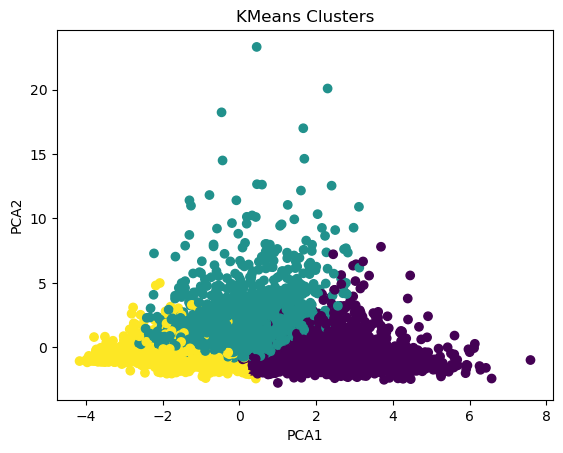

In [113]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_filtered)

# Visualize
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("KMeans Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


In [114]:
joblib.dump(log_reg, 'logistic_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(preprocessor, 'preprocessor_pipeline.pkl')
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(y_train, 'y_train.pkl')


['y_train.pkl']